This notebook is a code-along to Andrej's lesson: https://www.youtube.com/watch?v=TCH_1BHY58I.
It is based on this 2003 paper: https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


He provides a dataset of names as an example, and we'll makemore names. The next cell explores the dataset.

In [1]:
# Create data sets
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

SEP_CHAR = '.'  # Separator character signifying end or start of a word
BLOCK_SIZE = 3  # Number of previous characters to use as input to predict the next character

def build_dataset(words):
    # Create a dataset as one-hot encoded vectors
    x, y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE  # Start with a BLOCK_SIZE of SEP_CHAR's
        for ch in w + SEP_CHAR:
            ix = ctoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # Crop and append
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

# Read in the names
words = open("names.txt").read().splitlines()

# Create mapping from characters to integers and vice versa
ctoi = {c:i + 1 for i,c in enumerate(sorted(list(set(''.join(words)))))}
ctoi[SEP_CHAR] = 0
itoc = {i:c for c,i in ctoi.items()}
NUM_CHARS = len(ctoi)

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print (f"Training, dev, test sets have {Xtr.shape[0]}, {Xdev.shape[0]}, {Xte.shape[0]} words")

Training, dev, test sets have 182625, 22655, 22866 words


In [78]:
EMBEDDING_DIMS = 10               # Dimension of character embeddings
HIDDEN_LAYER_DIM = 100            # Dimension of hidden layers

# Create a model
class Model():
    """ Model for predicting the next character given a sequence of characters """
    def __init__(self):
        self.C = torch.randn((NUM_CHARS, EMBEDDING_DIMS)) * .1 # A map of characters to their embeddings
        self.C.requires_grad = True
        self.layers = [
            torch.nn.Linear(EMBEDDING_DIMS * BLOCK_SIZE, 100, bias=False),
            torch.nn.BatchNorm1d(HIDDEN_LAYER_DIM, momentum=0.01),
            torch.nn.Tanh(),

            torch.nn.Linear(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM, bias=False),
            torch.nn.BatchNorm1d(HIDDEN_LAYER_DIM, momentum=0.01),
            torch.nn.Tanh(),

            torch.nn.Linear(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM, bias=False),
            torch.nn.BatchNorm1d(HIDDEN_LAYER_DIM, momentum=0.01),
            torch.nn.Tanh(),

            torch.nn.Linear(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM, bias=False),
            torch.nn.BatchNorm1d(HIDDEN_LAYER_DIM, momentum=0.01),
            torch.nn.Tanh(),

            torch.nn.Linear(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM, bias=False),
            torch.nn.BatchNorm1d(HIDDEN_LAYER_DIM, momentum=0.01),
            torch.nn.Tanh(),

            torch.nn.Linear(HIDDEN_LAYER_DIM, NUM_CHARS, bias=False),
            torch.nn.BatchNorm1d(NUM_CHARS, momentum=0.01),
        ]

        self.layers[-1]
        self.parameters = [self.C] + [p for l in self.layers for p in l.parameters()]

    def __call__(self, x):
        x = self.C[x]
        x = x.view (x.shape[0], -1)
        for l in self.layers:
            x = l(x)
            l.out = x
        return x

    def parameters(self):
        return self.parameters

    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

    def step(self, lr):
        for p in self.parameters:
            p.data -= lr * p.grad

    def __repr__(self):
        repr = f"Model with {len(model.parameters)} parameters and {sum([p.numel() for p in model.parameters])} trainable elements\n"
        for layer_num, layer in enumerate(self.layers):
            if isinstance(layer, torch.nn.Linear):
                repr += f"\tLayer {layer_num}: \t{layer.__class__.__name__} {layer.weight.shape[1]} x {layer.weight.shape[0]}\n"
            else:
                repr += f"\tLayer {layer_num}: \t{layer.__class__.__name__}\n"
        return repr

HIDDEN_UNITS = 100      # Number of hidden units
model = Model()
loss_fn = F.cross_entropy

print (model)

Model with 19 parameters and 47024 trainable elements
	Layer 0: 	Linear 30 x 100
	Layer 1: 	BatchNorm1d
	Layer 2: 	Tanh
	Layer 3: 	Linear 100 x 100
	Layer 4: 	BatchNorm1d
	Layer 5: 	Tanh
	Layer 6: 	Linear 100 x 100
	Layer 7: 	BatchNorm1d
	Layer 8: 	Tanh
	Layer 9: 	Linear 100 x 100
	Layer 10: 	BatchNorm1d
	Layer 11: 	Tanh
	Layer 12: 	Linear 100 x 100
	Layer 13: 	BatchNorm1d
	Layer 14: 	Tanh
	Layer 15: 	Linear 100 x 27
	Layer 16: 	BatchNorm1d



Training the model with input shape torch.Size([182625, 3]), output shape torch.Size([182625]), steps=200000, batch_size=32, lr=0.01
Step 0, dev loss = 3.794179677963257
Step 10000, dev loss = 2.2372310161590576
Step 20000, dev loss = 2.191474676132202
Step 30000, dev loss = 2.1766111850738525
Step 40000, dev loss = 2.157653570175171
Step 50000, dev loss = 2.1528706550598145
Step 60000, dev loss = 2.147796154022217
Step 70000, dev loss = 2.1373119354248047
Step 80000, dev loss = 2.1357529163360596
Step 90000, dev loss = 2.128142833709717
Step 100000, dev loss = 2.124835968017578
Step 110000, dev loss = 2.1188647747039795
Step 120000, dev loss = 2.1157877445220947
Step 130000, dev loss = 2.1128089427948
Step 140000, dev loss = 2.1103601455688477
Step 150000, dev loss = 2.1093802452087402
Step 160000, dev loss = 2.1119985580444336
Step 170000, dev loss = 2.108855724334717
Step 180000, dev loss = 2.10427188873291
Step 190000, dev loss = 2.103898525238037


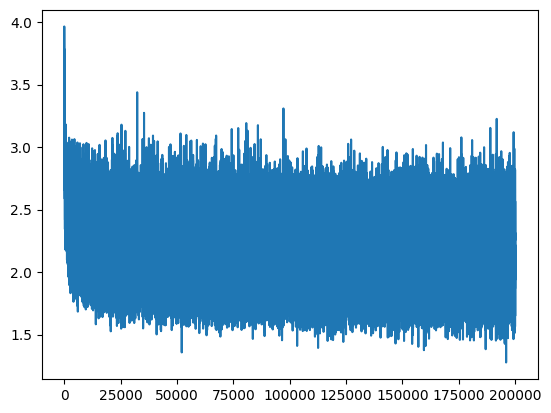

In [87]:
# Train the model
def train(model, x, y, xdev, ydev, steps, batch_size=None, lr=.001):
    debug = False
    print (f"Training the model with input shape {x.shape}, output shape {y.shape}, steps={steps}, batch_size={batch_size}, lr={lr}")
    dev_losses = []
    losses = []
    ud = []
    if batch_size is None:
        batch_size = x.shape[0]
    for i in range(steps):
        # sample a random subset of the training data
        ix_batch = torch.randint(0, x.shape[0], (batch_size,))
        x_batch = x[ix_batch]
        y_batch = y[ix_batch]

        # forward pass
        logits = model(x_batch)
        # print logits device
        loss = loss_fn(logits, y_batch)

        # backwards pass
        for l in model.layers:
            l.out.retain_grad()
        model.zero_grad()
        loss.backward()

        # update parameters
        model.step(lr)

        # Update per-step metrics
        losses.append(loss.item())
        with torch.no_grad():
            ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in model.parameters])

        # periodically print loss on the dev set
        if i % 10000 == 0:
            with torch.no_grad():
                logits = model(xdev)
                dev_loss = loss_fn(logits, ydev)
            print (f"Step {i}, dev loss = {dev_loss.item()}")
            dev_losses.append(dev_loss.item())

    model.ud = ud
    model.losses = losses
    
    plt.plot(list(range(len(losses))), losses, label="dev loss")

model = Model()
for layer in model.layers:
    if isinstance(layer, torch.nn.Linear):
        layer.weight.data *= 5/3
train(model, Xtr, Ytr, Xdev, Ydev, steps=200000, lr=.01, batch_size=32)

layer 2 (Tanh) mean = 0.00, std = 0.63, saturated = 6.72%
layer 5 (Tanh) mean = -0.00, std = 0.65, saturated = 7.19%
layer 8 (Tanh) mean = -0.01, std = 0.68, saturated = 6.41%
layer 11 (Tanh) mean = -0.01, std = 0.69, saturated = 6.34%
layer 14 (Tanh) mean = 0.01, std = 0.71, saturated = 4.84%


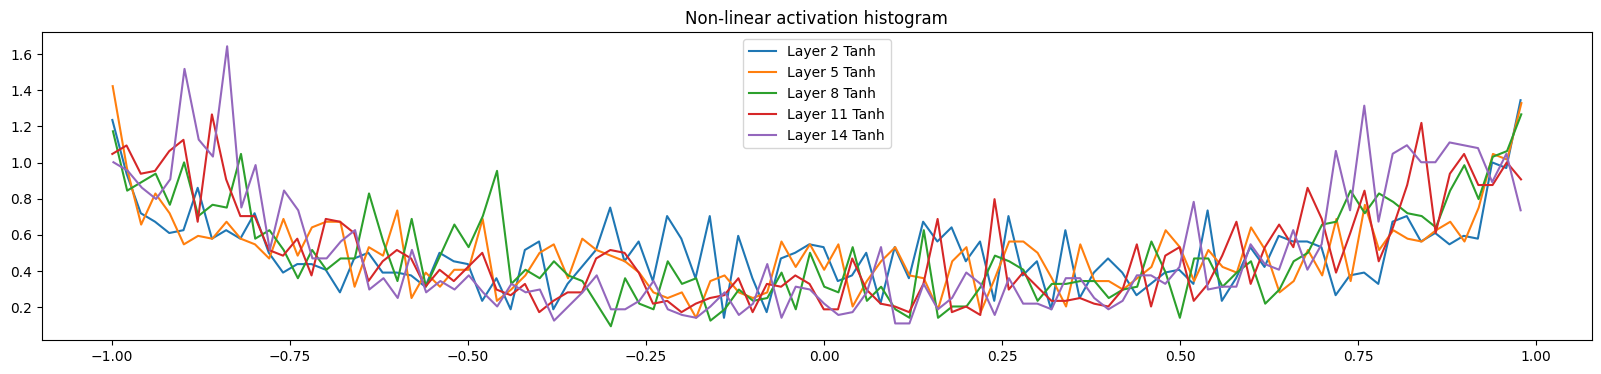

In [88]:
# Visualize non-linear activation histogram
plt.figure(figsize=(20, 4))

legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, torch.nn.Tanh):
        print (f"layer {i} ({layer.__class__.__name__}) mean = {layer.out.mean().item():.2f}, std = {layer.out.std().item():.2f}, saturated = {((layer.out.abs() > 0.97)).float().mean().item()*100:.2f}%")
        hy, hx = torch.histogram (layer.out, density=True)
        plt.plot (hx[:-1].detach(), hy.detach())
        legends.append (f"Layer {i} {layer.__class__.__name__}")

plt.title("Non-linear activation histogram")
plt.legend(legends)
plt.show()


layer 2 (Tanh) mean = 0.00, std = 0.63, saturated = 0.07
layer 5 (Tanh) mean = -0.00, std = 0.65, saturated = 0.07
layer 8 (Tanh) mean = -0.01, std = 0.68, saturated = 0.06
layer 11 (Tanh) mean = -0.01, std = 0.69, saturated = 0.06
layer 14 (Tanh) mean = 0.01, std = 0.71, saturated = 0.05


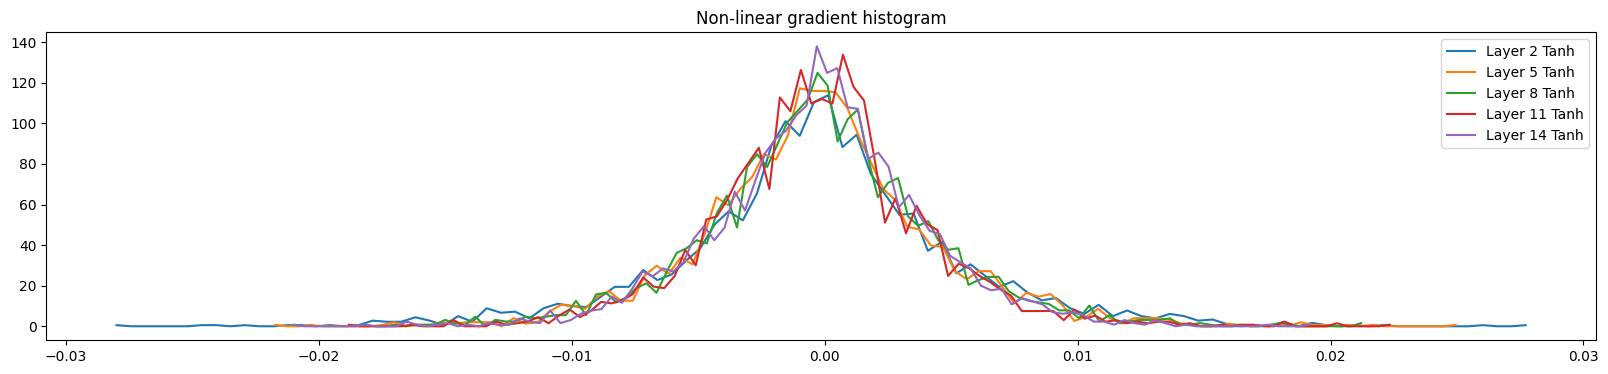

In [89]:
# Visualize non-linear gradient histogram
plt.figure(figsize=(20, 4))

legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, torch.nn.Tanh):
        print (f"layer {i} ({layer.__class__.__name__}) mean = {layer.out.mean().item():.2f}, std = {layer.out.std().item():.2f}, saturated = {((layer.out.abs() > 0.97)).float().mean().item():.2f}")
        hy, hx = torch.histogram (layer.out.grad, density=True)
        plt.plot (hx[:-1].detach(), hy.detach())
        legends.append (f"Layer {i} {layer.__class__.__name__}")

plt.title("Non-linear gradient histogram")
plt.legend(legends)
plt.show()

weight   (27, 10) | mean +0.000000 | std 4.361919e-02 | grad:data std ratio 1.475412e-01
weight  (100, 30) | mean +0.000232 | std 1.778176e-02 | grad:data std ratio 9.193754e-02
weight (100, 100) | mean -0.000115 | std 1.264529e-02 | grad:data std ratio 1.084915e-01
weight (100, 100) | mean -0.000038 | std 1.271609e-02 | grad:data std ratio 1.087919e-01
weight (100, 100) | mean -0.000061 | std 1.303896e-02 | grad:data std ratio 1.135266e-01
weight (100, 100) | mean +0.000200 | std 1.141690e-02 | grad:data std ratio 1.009880e-01
weight  (27, 100) | mean -0.000077 | std 1.998172e-02 | grad:data std ratio 1.396044e-01


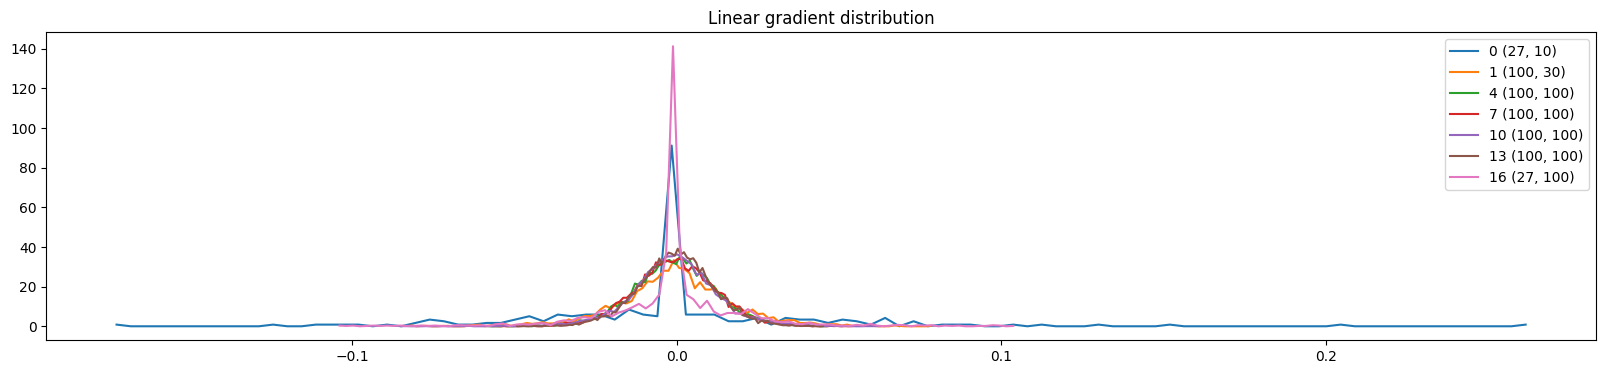

In [90]:
# Visualize linear layer gradient/data distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data std ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Linear gradient distribution');

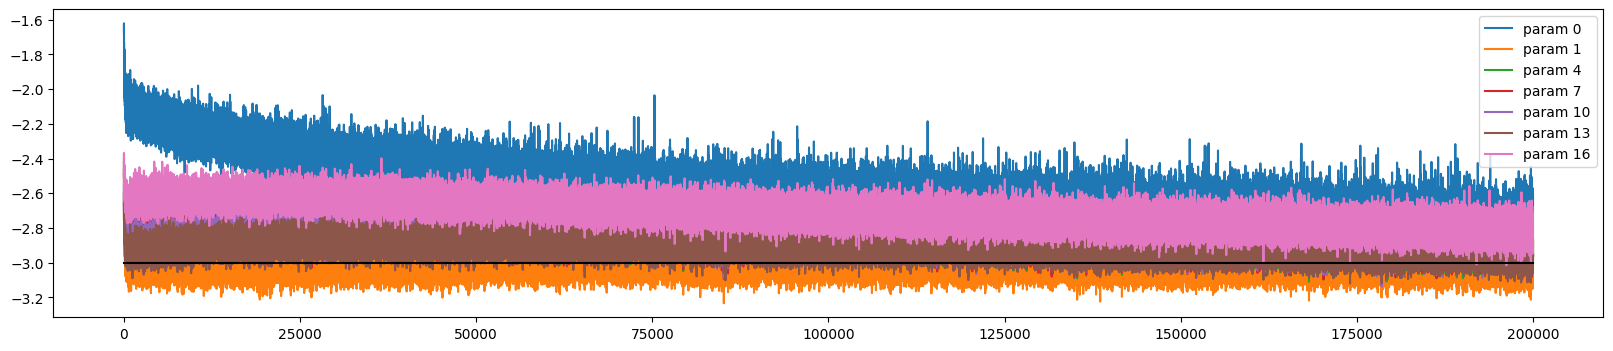

In [91]:
ud = model.ud # gradient/data std ratio

# Visualize how the update/data ration changes over time
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters):
  if i == 0:
    pass
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Training loss = 2.047480821609497
Dev loss = 2.1004397869110107
Test loss = 2.101173162460327
kynsiedvienesdreeca
aleigh
weley
amalynn
dargareen
chasie
ston
mervini
kathe
kardette


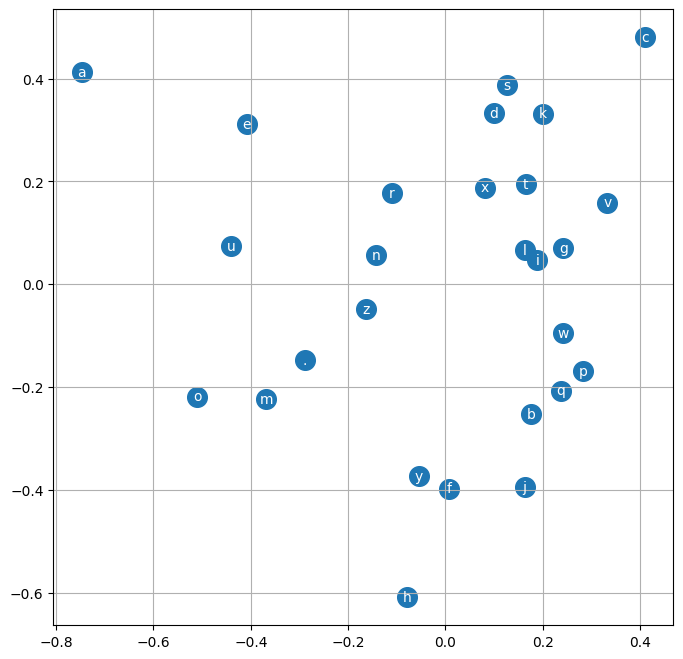

In [96]:
# Test the model and visualize the embeddings
@torch.no_grad()
def test(x, y):
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    print (f"loss = {loss.item()}")

# Visualize the embeddings
def visualize_embeddings():
    plt.figure(figsize=(8,8))
    C = model.C
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    for i in range(NUM_CHARS):
        plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
    plt.grid("minor")
    plt.show()

def makemore(num):
    for layer in model.layers:
        layer.eval()
    # Generate num new names
    for _ in range(num):
        context = [0] * BLOCK_SIZE
        name = ""
        while True:
            logits = model(torch.tensor(context).view(1, -1))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            if ix == 0:
                break
            name += itoc[ix]
            context = context[1:] + [ix]
        print (name)

print ("Training ", end="")
test(Xtr, Ytr)
print ("Dev ", end="")
test(Xdev, Ydev)
print ("Test ", end="")
test(Xte, Yte)

makemore(10)

visualize_embeddings()